Our project looks to examine the key factors influencing NBA player scoring, utilizing a comprehensive dataset of player statistics from 1950 to 2017. By examining a wide range of features from our dataset—including player position, minutes played, field goal percentage, and usage rate—we seek to identify the elements that contribute most significantly to a player's scoring ability, and to be able to predict future stats with our supervised learning model (supervised because we have quantitative labeled data). In addition, we want to know which combinations of these features are the best predictors for high point totals in an NBA player's entire career. The insights gained from this study can be a valuable resource for sports bettors, fantasy basketball players, and even the coaches or GMs who manage the team themselves when trying to pick players with the best scoring potential.

In [ ]:
!git clone https://github.com/jonathanaduong/CSE151AGroupProject.git

fatal: destination path 'CSE151AGroupProject' already exists and is not an empty directory.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [ ]:
nbadf = pd.read_csv('CSE151AGroupProject/Seasons_Stats.csv')
nbadf.head(20)

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0
5,5,1950.0,Ed Bartels,F,24.0,NYK,2.0,NaN,NaN,NaN,...,0.667,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2.0,4.0
6,6,1950.0,Ralph Beard,G,22.0,INO,60.0,NaN,NaN,NaN,...,0.762,NaN,NaN,NaN,233.0,NaN,NaN,NaN,132.0,895.0
7,7,1950.0,Gene Berce,G-F,23.0,TRI,3.0,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.0,10.0
8,8,1950.0,Charlie Black,F-C,28.0,TOT,65.0,NaN,NaN,NaN,...,0.651,NaN,NaN,NaN,163.0,NaN,NaN,NaN,273.0,661.0
9,9,1950.0,Charlie Black,F-C,28.0,FTW,36.0,NaN,NaN,NaN,...,0.632,NaN,NaN,NaN,75.0,NaN,NaN,NaN,140.0,382.0


In [ ]:
nbadf.dtypes

,0
Unnamed: 0,int64
Year,float64
Player,object
Pos,object
Age,float64
Tm,object
G,float64
GS,float64
MP,float64
PER,float64


In [ ]:
print(nbadf.Pos.unique())

['G-F' 'SG' 'SF' 'F' 'G' 'F-C' 'PG' 'F-G' 'C' 'PF' 'C-F' nan 'PF-C'
 'SF-SG' 'C-PF' 'SG-SF' 'PF-SF' 'SF-PF' 'SG-PG' 'SF-PG' 'C-SF' 'PG-SG'
 'PG-SF' 'SG-PF']


In [ ]:
nbadf.describe()

,Unnamed: 0,Year,Age,G,GS,MP,PER,TS%,3PAr,FTr,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,24691.000000,24624.000000,24616.000000,24624.000000,18233.000000,24138.000000,24101.000000,24538.000000,18839.000000,24525.000000,...,23766.000000,20797.000000,20797.000000,24312.000000,24624.000000,20797.000000,20797.000000,19645.000000,24624.000000,24624.000000
mean,12345.000000,1992.594989,26.664405,50.837110,23.593375,1209.720317,12.479071,0.493001,0.158604,0.325455,...,0.719279,62.189210,147.199404,224.637381,114.852623,39.897052,24.470260,73.939832,116.339222,510.116350
std,7127.822084,17.429594,3.841892,26.496161,28.632387,941.146575,6.039014,0.094469,0.187495,0.218971,...,0.141824,67.324881,145.921912,228.190203,135.863913,38.713053,36.935084,67.713803,84.791873,492.922981
min,0.000000,1950.000000,18.000000,1.000000,0.000000,0.000000,-90.600000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6172.500000,1981.000000,24.000000,27.000000,0.000000,340.000000,9.800000,0.458000,0.005000,0.208000,...,0.657000,12.000000,33.000000,51.000000,19.000000,9.000000,3.000000,18.000000,39.000000,106.000000
50%,12345.000000,1996.000000,26.000000,58.000000,8.000000,1053.000000,12.700000,0.506000,0.064000,0.296000,...,0.743000,38.000000,106.000000,159.000000,68.000000,29.000000,11.000000,55.000000,109.000000,364.000000
75%,18517.500000,2007.000000,29.000000,75.000000,45.000000,1971.000000,15.600000,0.544000,0.288000,0.400000,...,0.808000,91.000000,212.000000,322.000000,160.000000,60.000000,29.000000,112.000000,182.000000,778.000000
max,24690.000000,2017.000000,44.000000,88.000000,83.000000,3882.000000,129.100000,1.136000,1.000000,6.000000,...,1.000000,587.000000,1111.000000,2149.000000,1164.000000,301.000000,456.000000,464.000000,386.000000,4029.000000


In [ ]:
print(nbadf.Tm.unique())

['FTW' 'INO' 'CHS' 'TOT' 'DNN' 'NYK' 'TRI' 'AND' 'PHW' 'WAT' 'SHE' 'ROC'
 'BLB' 'MNL' 'SYR' 'WSC' 'BOS' 'STB' nan 'MLH' 'STL' 'DET' 'CIN' 'LAL'
 'CHP' 'SFW' 'CHZ' 'BAL' 'PHI' 'CHI' 'SDR' 'SEA' 'MIL' 'ATL' 'PHO' 'POR'
 'CLE' 'BUF' 'HOU' 'GSW' 'KCO' 'CAP' 'NOJ' 'WSB' 'KCK' 'IND' 'NYN' 'DEN'
 'SAS' 'NJN' 'SDC' 'UTA' 'DAL' 'LAC' 'SAC' 'CHH' 'MIA' 'ORL' 'MIN' 'VAN'
 'TOR' 'WAS' 'MEM' 'NOH' 'CHA' 'NOK' 'OKC' 'BRK' 'NOP' 'CHO']


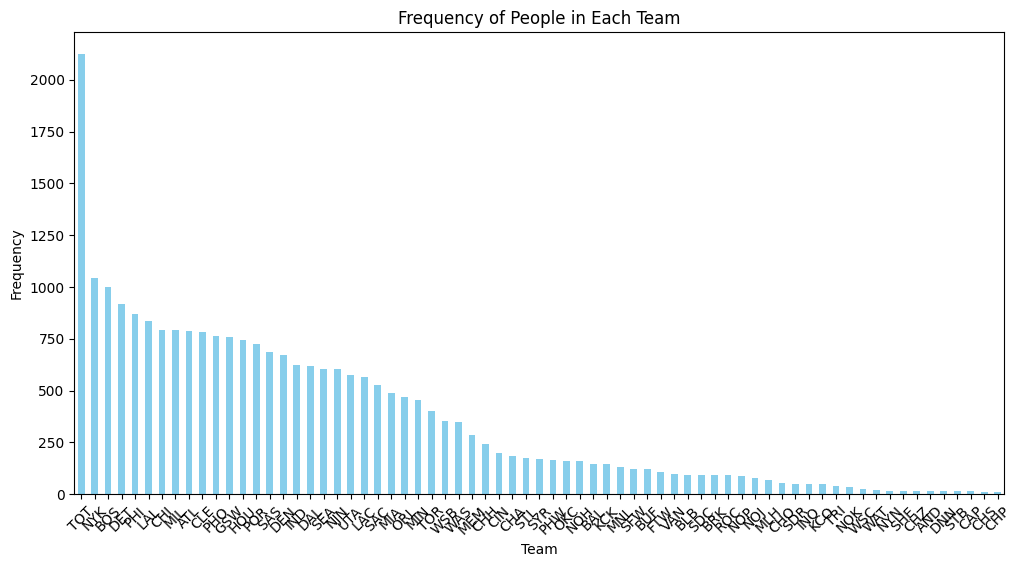

In [ ]:
team_counts = nbadf['Tm'].value_counts()

plt.figure(figsize=(12, 6))
team_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of People in Each Team')
plt.xlabel('Team')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

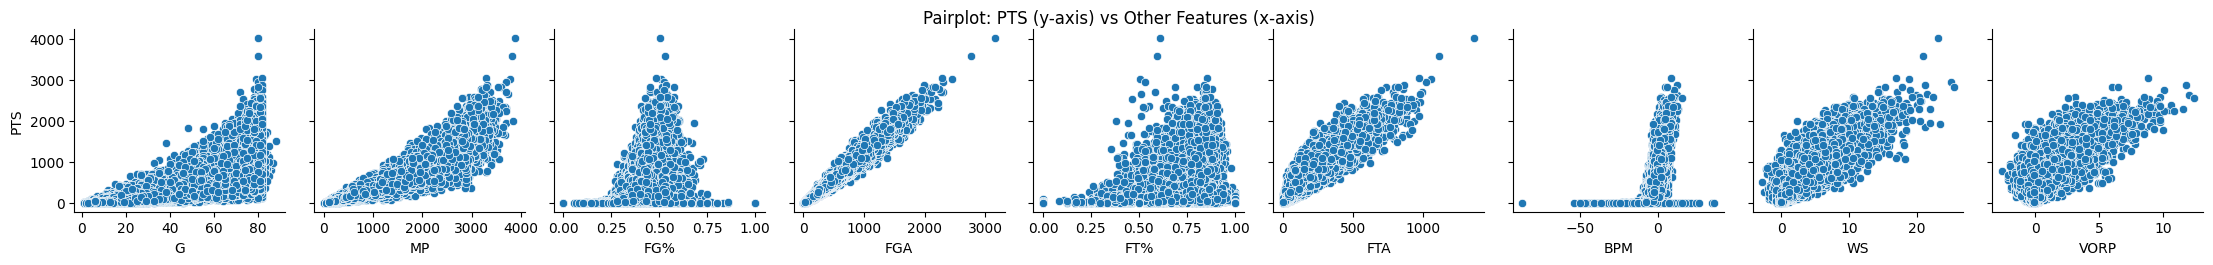

In [ ]:

columns = ['PTS', 'G', 'MP', 'FG%', 'FGA', 'FT%', 'FTA','BPM','WS','VORP']

# Create a PairGrid with 'PTS' as the y-axis for all other features
g = sns.PairGrid(nbadf, y_vars=['PTS'], x_vars=columns[1:])  # Exclude 'PTS' from x_vars
g.map(sns.scatterplot)  # Use scatter plots for visualization

# Adjust layout and display
g.fig.suptitle("Pairplot: PTS (y-axis) vs Other Features (x-axis)", y=1.02)
plt.show()

<Axes: >

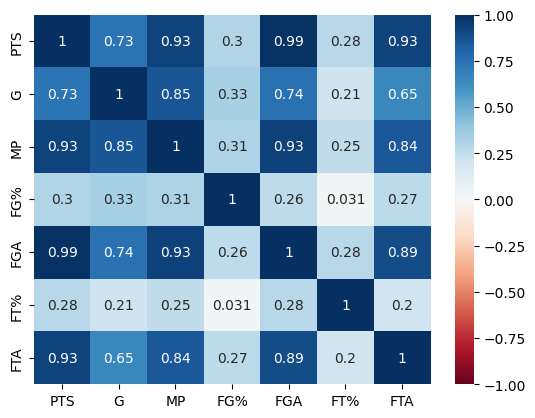

In [ ]:
corr = nbadf[['PTS', 'G', 'MP', 'FG%', 'FGA', 'FT%', 'FTA']].corr()
sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True, cmap= 'RdBu')

In [ ]:
nbadf.isnull().sum()

,0
Unnamed: 0,0
Year,67
Player,67
Pos,67
Age,75
Tm,67
G,67
GS,6458
MP,553
PER,590


The data set tracks players' statistics season to season from 1950-2017. The categorical features we plan on observing are Pos (Player position) and Tm (Team they played for) and the numerical features that we plan to observe are G (Games played), MP (Total minutes played), FG% (Percentage hots made in a season), FGA (Shots attempted in a season), FT% (Percentage of free throws made in a season), and FTA (Free throws attempted in a season).

We plan on predicting the points scored per game for an individual, so we need to observe the games played each season for a player (G) as FGA, FTA, and MP are the totals for points scored, field goals shot, free throws shot, and minutes played for the season rather than a per game average, which we would prefer to analyze. We will also be seeing if player position makes a difference in the point scored per game.

The data set has 24,691 different observations, although there are repeat players since they played across multiple years. For scale, we plan to use minMax scaling to ensure that the data is normalized. There are many null/NaN values across seasons since these statistics were not recorded at the time, such as blocks or steals.


### How will you preprocess your data :
- to (one-hot) encode categorical data like Team, Positions
- for null/nan values, we will replace it with an adjusted mean values
- for each of the season total categories (PTS, TRB, AST), we will divide it by the games played to get the per game average.
- use min-max to scale since we do

In [ ]:
processed_nbadf = nbadf.copy()
removeFeat =  ['Unnamed: 0', 'blanl' , 'blank2', 'GS', 'Player', 'ORB', 'DRB', '3P', '2P', 'FG',]
processed_nbadf = processed_nbadf.drop(removeFeat, axis=1)

#fill NaNs in each non-category column
for i in processed_nbadf.columns:
  if i == 'Year': continue
  if i == 'MP': continue
  if processed_nbadf[i].dtype == 'object': continue
  #by mean imputation grouped by year:
  processed_nbadf[i] = processed_nbadf.groupby('Year')[i].transform(lambda x: x.fillna(x.mean()))
  col_mean = processed_nbadf[i].mean()
  #by global average:
  processed_nbadf[i] = processed_nbadf[i].fillna(col_mean)

#compute average MP per game
avg_MP = processed_nbadf["MP"].mean()
avg_G = processed_nbadf["G"].mean()
processed_nbadf['MP_per_game'] = processed_nbadf['MP'] / processed_nbadf['G']
#fill NaNs with the global average
processed_nbadf['MP_per_game'] = processed_nbadf['MP_per_game'].fillna(avg_MP / avg_G)
processed_nbadf = processed_nbadf.drop(['MP'], axis=1)
#remove remaining NaNs
processed_nbadf.dropna(inplace= True)

# #one-hot encode categories
processed_nbadf = pd.get_dummies(processed_nbadf, columns=['Tm', 'Pos'])
processed_nbadf

#compute per game and fill out na values with mean
feature_cols = []
for column in ['PTS', 'TRB', 'AST', 'FGA', '3PA', '2PA', 'FTA']:
  col = column + '_per_game'
  feature_cols.append(col)
  processed_nbadf[col] = processed_nbadf[column] / processed_nbadf['G']
  processed_nbadf.drop(column, axis = 1)

processed_nbadf.head()

,Year,Age,G,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,...,Pos_SG-PF,Pos_SG-PG,Pos_SG-SF,PTS_per_game,TRB_per_game,AST_per_game,FGA_per_game,3PA_per_game,2PA_per_game,FTA_per_game
0,1950.0,31.0,63.0,12.47864,0.368,0.158679,0.467,6.181471,13.708809,9.949237,...,False,False,False,7.269841,3.565673,2.793651,8.190476,1.009595,8.190476,3.825397
1,1950.0,29.0,49.0,12.47864,0.435,0.158679,0.387,6.181471,13.708809,9.949237,...,False,False,False,5.693878,4.584436,2.224490,5.591837,1.298051,5.591837,2.163265
2,1950.0,25.0,67.0,12.47864,0.394,0.158679,0.259,6.181471,13.708809,9.949237,...,False,False,False,6.537313,3.352797,2.089552,7.447761,0.949321,7.447761,1.925373
3,1950.0,24.0,15.0,12.47864,0.312,0.158679,0.395,6.181471,13.708809,9.949237,...,False,False,False,4.200000,14.975825,1.333333,5.733333,4.240299,5.733333,2.266667
4,1950.0,24.0,13.0,12.47864,0.308,0.158679,0.378,6.181471,13.708809,9.949237,...,False,False,False,4.538462,17.279799,1.538462,6.307692,4.892652,6.307692,2.384615


In [ ]:
processed_nbadf.isnull().sum()

,0
Year,0
Age,0
G,0
PER,0
TS%,0
...,...
AST_per_game,0
FGA_per_game,0
3PA_per_game,0
2PA_per_game,0


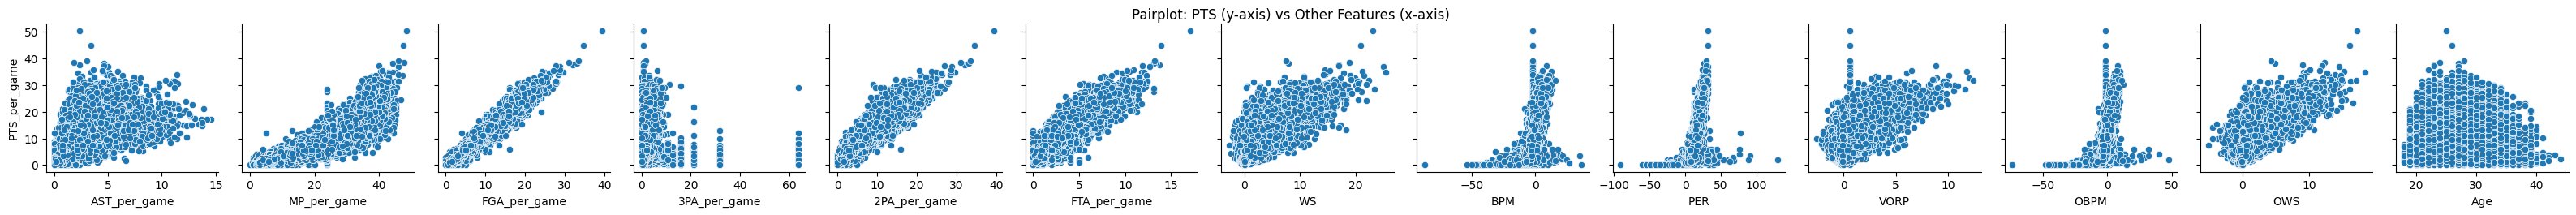

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the subset of features
columns = ['TRB_per_game', 'AST_per_game', 'MP_per_game', 'FGA_per_game', '3PA_per_game', '2PA_per_game', 'FTA_per_game','WS','BPM', 'PER','VORP','OBPM','OWS','Age']

# Create a PairGrid with 'PTS' as the y-axis for all other features
g = sns.PairGrid(processed_nbadf, y_vars=['PTS_per_game'], x_vars=columns[1:])  # Exclude 'PTS' from x_vars
g.map(sns.scatterplot)  # Use scatter plots for visualization

# Adjust layout and display
g.fig.suptitle("Pairplot: PTS (y-axis) vs Other Features (x-axis)", y=1.02)
plt.show()

## First Model

Our first model uses Linear Regression to train on the per game statistics such as total rebounds, assists, field goals attempted, 3 point attempts made, 2-point attempts made, free throw attemps made.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processed_nbadf[['TRB_per_game', 'AST_per_game', 'MP_per_game', '3PA_per_game', '2PA_per_game', 'FTA_per_game','WS','BPM', 'PER','VORP','Age', 'OBPM','FGA_per_game']], processed_nbadf.PTS_per_game, test_size=0.2, random_state=22)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [ ]:
X_test.describe()


,TRB_per_game,AST_per_game,MP_per_game,3PA_per_game,2PA_per_game,FTA_per_game,WS,BPM,PER,VORP,Age,OBPM,FGA_per_game
count,4925.000000,4925.000000,4925.000000,4925.000000,4925.000000,4925.000000,4925.000000,4925.000000,4925.000000,4925.000000,4925.000000,4925.000000,4925.000000
mean,0.016819,0.127197,0.416555,0.024311,0.158486,0.130835,0.187599,0.686748,0.469717,0.210585,0.330104,0.592331,0.179247
std,0.013468,0.121727,0.213035,0.063611,0.116796,0.109778,0.109313,0.034409,0.027662,0.081362,0.147876,0.027506,0.123470
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031915,0.327909,0.213473,0.033333,0.000000,0.334704,0.000000
25%,0.007683,0.041941,0.236449,0.000971,0.069753,0.052172,0.106383,0.676159,0.457442,0.166667,0.230769,0.582237,0.081983
50%,0.013355,0.088809,0.405289,0.012346,0.126622,0.098853,0.148936,0.686520,0.469731,0.186667,0.307692,0.592283,0.149496
75%,0.022258,0.174673,0.590417,0.027156,0.221465,0.179092,0.237589,0.703824,0.483386,0.213333,0.423077,0.606086,0.250816
max,0.200000,0.946187,0.980422,1.000000,0.876860,0.816581,0.875887,0.921888,0.823396,0.873333,0.961538,0.840461,0.876860


In [ ]:
X_train.describe()

,TRB_per_game,AST_per_game,MP_per_game,3PA_per_game,2PA_per_game,FTA_per_game,WS,BPM,PER,VORP,Age,OBPM,FGA_per_game
count,19699.000000,19699.000000,19699.000000,19699.000000,19699.000000,19699.000000,19699.000000,19699.000000,19699.000000,19699.000000,19699.000000,19699.000000,19699.000000
mean,0.017230,0.130687,0.421242,0.024529,0.159463,0.132520,0.187418,0.686463,0.469045,0.210677,0.334020,0.592271,0.181113
std,0.020480,0.124467,0.211727,0.061976,0.115192,0.110636,0.108146,0.035250,0.027075,0.082046,0.147702,0.028949,0.121788
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.007682,0.043651,0.243787,0.000995,0.070346,0.053104,0.106383,0.676159,0.457442,0.166667,0.230769,0.582237,0.085182
50%,0.013355,0.092666,0.410063,0.012500,0.129155,0.101295,0.148936,0.686520,0.469731,0.186667,0.307692,0.592283,0.152259
75%,0.022258,0.177048,0.592543,0.028022,0.223779,0.181952,0.234043,0.704638,0.482931,0.213333,0.423077,0.606908,0.253911
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
print(X_train.shape[0]/processed_nbadf.shape[0])
print(X_test.shape[0]/processed_nbadf.shape[0])

0.799991877842755
0.20000812215724498


In [ ]:
  linearreg = LinearRegression()
  ## y_train and y_test serve as ground truth labels, representing the actual points per game derived from our dataset. These values were calculated by dividing each player’s total points in the season by the number of games played, providing a reliable basis for evaluating the model's predictions.
  linearmodel = linearreg.fit(X_train, y_train)
  yhat_test = linearreg.predict(X_test)
  yhat_train = linearreg.predict(X_train)

  print('Training MSE: %.2f' % mean_squared_error(y_train, yhat_train))
  print('Testing MSE: %.2f' % mean_squared_error(y_test, yhat_test))
  print("Coefficients:", linearmodel.coef_)
  print("Intercept:", linearmodel.intercept_)

Training MSE: 0.52
Testing MSE: 0.50
Coefficients: [-4.2614373  -1.42741702  0.23164253 -0.79862453 -7.9158575  10.2326818
  6.30703504 -4.92944255 10.39803628  0.54434877  0.08297025  8.85255046
 42.98666333]
Intercept: -7.431657710794822


In [ ]:
X_train = X_train.drop('FGA_per_game',axis = 1)
X_test = X_test.drop('FGA_per_game',axis = 1)
linearmodel = linearreg.fit(X_train, y_train)
yhat_test = linearreg.predict(X_test)
yhat_train = linearreg.predict(X_train)

print('Training MSE for no FGA: %.2f' % mean_squared_error(y_train, yhat_train))
print('Testing MSE for no FGA: %.2f' % mean_squared_error(y_test, yhat_test))

Training MSE for no FGA: 1.65
Testing MSE for no FGA: 1.59


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True)
cv_scores = cross_val_score(linearmodel, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
print('Cross-Validation Scores:', -cv_scores)

Cross-Validation Scores: [0.46139252 0.48908755 0.5362284  0.48781997 0.54074659 0.49958713
 0.50085788 0.52959658 0.53930553 0.60954084]


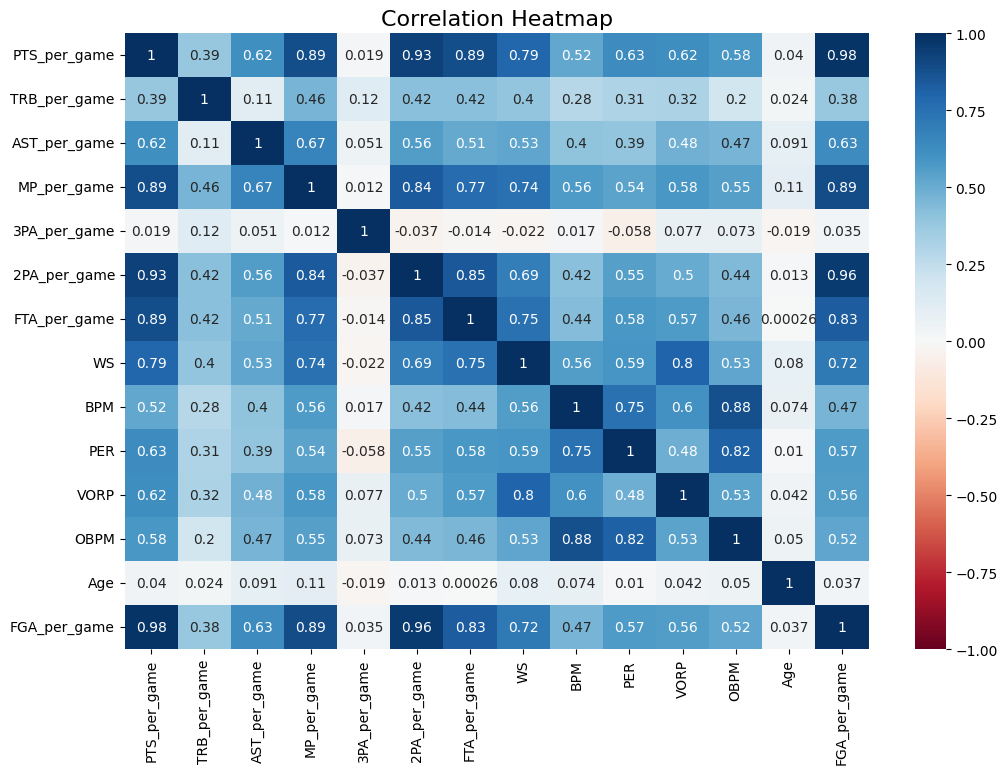

In [ ]:

# Calculate the correlation matrix
corr = processed_nbadf[['PTS_per_game','TRB_per_game', 'AST_per_game', 'MP_per_game', '3PA_per_game', '2PA_per_game', 'FTA_per_game','WS','BPM', 'PER','VORP','OBPM','Age', 'FGA_per_game']].corr()
# Set up the figure size
plt.figure(figsize=(12, 8))  # Adjust the width (12) and height (8) as needed

# Plot the heatmap
sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True, cmap='RdBu')
plt.title("Correlation Heatmap", fontsize=16)

# Show the plot
plt.show()

## Conclusion
The conclusion of our 1st model shows our model can achieve a moderate level of accuracy in predicting PPG. To improve our model in the future, we might want to exclude most of the data from 1950s to 1980s because lots of the data had to be imputed and are carried by global averages.

#Model 2

In model 2, we included additional features, such as Win Shares, box plus-minus and player efficiency ratings and fitted them into different degrees of polynomial regressions ranging from 1 to 4.

Polynomial Regression (Degree=1)
Train MSE: 1.65
Test MSE: 1.59
Polynomial Regression (Degree=2)
Train MSE: 0.54
Test MSE: 0.57
Polynomial Regression (Degree=3)
Train MSE: 0.34
Test MSE: 0.44
Polynomial Regression (Degree=4)
Train MSE: 0.21
Test MSE: 88.83


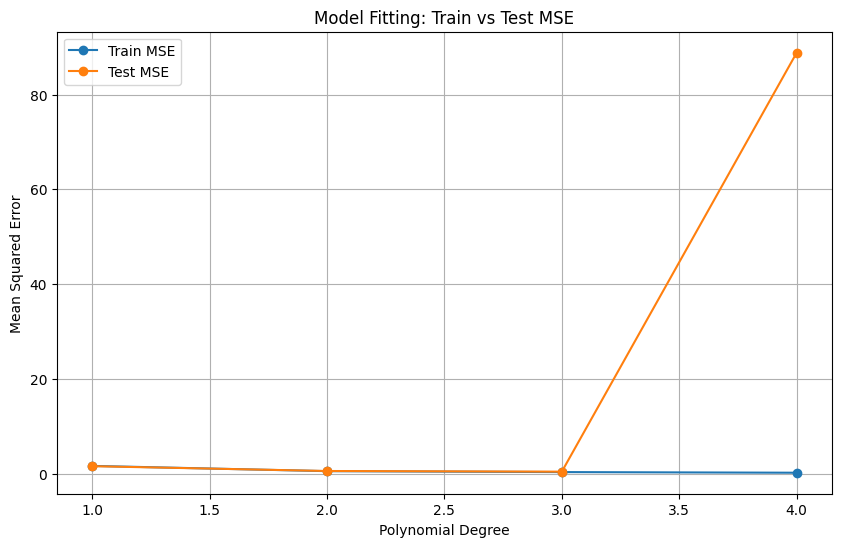

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
y = processed_nbadf.PTS_per_game
X_train, X_test, y_train, y_test = train_test_split(processed_nbadf[['TRB_per_game', 'AST_per_game', 'MP_per_game', '3PA_per_game', '2PA_per_game', 'FTA_per_game','WS','BPM', 'PER','VORP','Age', 'OBPM']], y, test_size=0.2, random_state=22)

# min max scale
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# turn X_train and X_test into
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

## for the fitting graph
train_mse_list = []
test_mse_list = []

# polynomial degree to add complexity to the model
degrees = [1,2,3,4]
for degree in degrees:
  initialDegree = degree
  poly = PolynomialFeatures(degree=initialDegree)
  X_train_poly = poly.fit_transform(X_train)
  X_test_poly = poly.transform(X_test)

  model2 = LinearRegression()
  model2.fit(X_train_poly, y_train)
  y_train_pred = model2.predict(X_train_poly)
  y_test_pred = model2.predict(X_test_poly)


  train_mse = mean_squared_error(y_train, y_train_pred)
  test_mse = mean_squared_error(y_test, y_test_pred)
  train_mse_list.append(train_mse)
  test_mse_list.append(test_mse)

  print(f"Polynomial Regression (Degree={initialDegree})")
  print(f"Train MSE: {train_mse:.2f}")
  print(f"Test MSE: {test_mse:.2f}")

## WILL CHOOSE Degree 3 for Polynomial Regression, better performance with
## least signs of overfitting
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_mse_list, marker='o', label='Train MSE')
plt.plot(degrees, test_mse_list, marker='o', label='Test MSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Model Fitting: Train vs Test MSE')
plt.legend()
plt.grid(True)
plt.show()

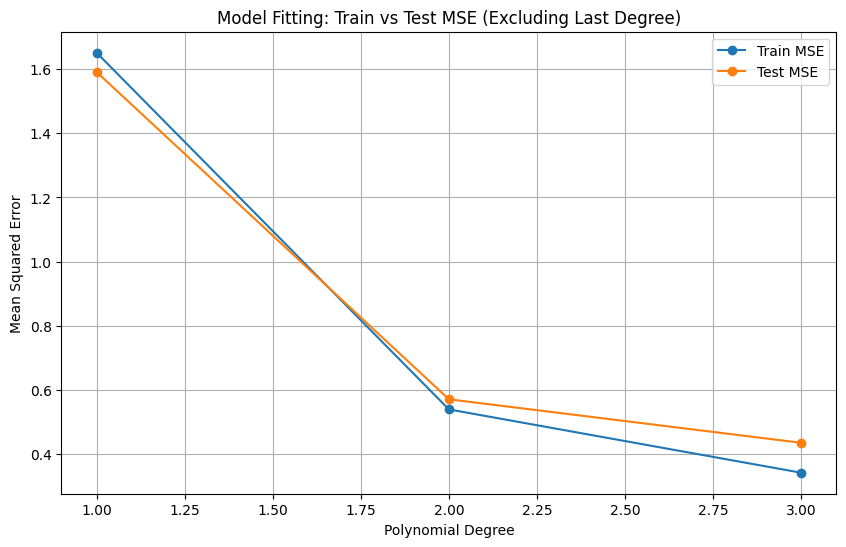

In [ ]:
plt.figure(figsize=(10, 6))
degrees_trimmed = degrees[:-1]
train_mse_list_trimmed = train_mse_list[:-1]
test_mse_list_trimmed = test_mse_list[:-1]
plt.plot(degrees_trimmed, train_mse_list_trimmed, marker='o', label='Train MSE')
plt.plot(degrees_trimmed, test_mse_list_trimmed, marker='o', label='Test MSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Model Fitting: Train vs Test MSE (Excluding Last Degree)')
plt.legend()
plt.grid(True)
plt.show()

3. Our model displays the key points of underfitting because of how closely our training data and test data follow each other despite starting to diverge at degree three. Our first model which also is a case of underfitting, omitted a key component of underfitting when complexity is low:high error. Our error is so low because looking at our features selected, things like 3PA, 2PA, and FTA are all directly responisble for ppg. Looking at our correlation of the features we selected

We see that our model may heavily rely on these features considering that things like FGA per game and 2PA per game are very correlated. 3PApg is so low because for the majority of NBA history, 3's were not a big part of the game so many great scorers of the past never shot threes.


We see omitting all of the highly correlated increases our error by a large percent(100%+), explaining our low error on both models considering both models are making use of these highly correlated features which is a great predictor of ppg.

In [ ]:
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
model2 = LinearRegression()
model2.fit(X_train_poly, y_train)
y_test_pred = model2.predict(X_test_poly)
y_test_pred
threshold = 1
newY = y_test - y_test_pred
# Define thresholds
thresholds = [0.5, 1, 2.5, 5,10]
newY = y_test - y_test_pred
correct = len(newY[abs(newY) < 0.5])
FNFP = len(y_test) - correct
fnfp_within_ranges = [
    len(newY[(abs(newY) > thresholds[i]) & (abs(newY) <= thresholds[i + 1])])
    for i in range(len(thresholds) - 1)
]

# Print results
print(f"Correct Values: {correct}")
print(f"FNFP Values: {FNFP}")
for i in range(len(thresholds) - 1):
    print(f"FNFP between {thresholds[i]} and {thresholds[i+1]}: {fnfp_within_ranges[i]}")


Correct Values: 3408
FNFP Values: 1517
FNFP between 0.5 and 1: 1055
FNFP between 1 and 2.5: 432
FNFP between 2.5 and 5: 25
FNFP between 5 and 10: 5


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True)
cv_scores = cross_val_score(model2, X_train_poly, y_train, cv=kf, scoring='neg_mean_squared_error')
print('Cross-Validation Scores:', -cv_scores)

Cross-Validation Scores: [ 0.43217879  0.46648901  0.43258806  0.57135784  0.39732678  0.51268138
  0.67144083 14.51494587  0.82262654  0.52637149]


#Model 3
For our third model, we will predict a player's **Points Per Game** as a **Category**. Specifically, we will bin PPG as follows:

|Bin|Score|
|----------|-------|
|PPG <= 25%|"Low"|
|25% < PPG <= 50%|"Medium"|
|50% < PPG <= 75%|"High"|
|PPG > 75%|"Very High"|

The thresholds are printed below:

In [ ]:
cols = ['PTS_per_game']
#ppg mean is 8.3; max is 50
desc = processed_nbadf[cols].describe()
desc

,PTS_per_game
count,24624.000000
mean,8.307698
std,6.075255
min,0.000000
25%,3.583333
50%,6.794872
75%,11.741162
max,50.362500


We will perform additional preprocessing for this version of our data by adding a new column into our modified DataFrame called "PPG Bin"

In [ ]:
bins = {"Low": desc["PTS_per_game"]["25%"], "Medium": desc["PTS_per_game"]["50%"], "High": desc["PTS_per_game"]["75%"]}
print(bins)
nbadf_2 = processed_nbadf.copy()

#Convert keys into numeric vals, Very High = 3
def PPG_binner(value):
    if value < bins['Low']:
        return 0
    elif value < bins['Medium']:
        return 1
    elif value < bins['High']:
        return 2
    else:
        return 3

#Apply the function to PTS_per_game
nbadf_2['PPG_Bins'] = nbadf_2['PTS_per_game'].apply(PPG_binner)
nbadf_2 = nbadf_2.drop("PTS_per_game", axis=1)
#Drop the PTS_per_game column
nbadf_2.head()

{'Low': 3.5833333333333335, 'Medium': 6.794871794871795, 'High': 11.741161616161616}


,Year,Age,G,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,...,Pos_SG-PF,Pos_SG-PG,Pos_SG-SF,TRB_per_game,AST_per_game,FGA_per_game,3PA_per_game,2PA_per_game,FTA_per_game,PPG_Bins
0,1950.0,31.0,63.0,12.47864,0.368,0.158679,0.467,6.181471,13.708809,9.949237,...,False,False,False,3.565673,2.793651,8.190476,1.009595,8.190476,3.825397,2
1,1950.0,29.0,49.0,12.47864,0.435,0.158679,0.387,6.181471,13.708809,9.949237,...,False,False,False,4.584436,2.224490,5.591837,1.298051,5.591837,2.163265,1
2,1950.0,25.0,67.0,12.47864,0.394,0.158679,0.259,6.181471,13.708809,9.949237,...,False,False,False,3.352797,2.089552,7.447761,0.949321,7.447761,1.925373,1
3,1950.0,24.0,15.0,12.47864,0.312,0.158679,0.395,6.181471,13.708809,9.949237,...,False,False,False,14.975825,1.333333,5.733333,4.240299,5.733333,2.266667,1
4,1950.0,24.0,13.0,12.47864,0.308,0.158679,0.378,6.181471,13.708809,9.949237,...,False,False,False,17.279799,1.538462,6.307692,4.892652,6.307692,2.384615,1


Now we can perform either PCA or SVD using the same dimensions as we did in our previous model.

We will not take into account the position of a player. This is because PCA using positions results in 5 clusters, binned most likely by the 5 main positions in a basketball team. Within those clusters, observations are clustered by PPG bins. A graph of the results is seen below.

In [ ]:
from IPython.display import Image

In [ ]:
Image('PCA_1.png')

FileNotFoundError: No such file or directory: 'PCA_1.png'

FileNotFoundError: No such file or directory: 'PCA_1.png'

<IPython.core.display.Image object>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    nbadf_2.iloc[:, -7:-1],
    nbadf_2.PPG_Bins,
    test_size=0.2,
    random_state=21)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_train.head()

,TRB_per_game,AST_per_game,FGA_per_game,3PA_per_game,2PA_per_game,FTA_per_game
19024,0.018567,0.211382,0.410133,0.040839,0.344351,0.486015
24154,0.035943,0.124829,0.075973,0.000582,0.075035,0.023912
23065,0.017714,0.022928,0.079667,0.000000,0.079667,0.030570
14562,0.007362,0.026455,0.060389,0.006047,0.050649,0.004515
16725,0.015102,0.094903,0.122776,0.034231,0.067639,0.086184


In [ ]:
y_train.head()

,PPG_Bins
19024,3
24154,0
23065,0
14562,0
16725,1


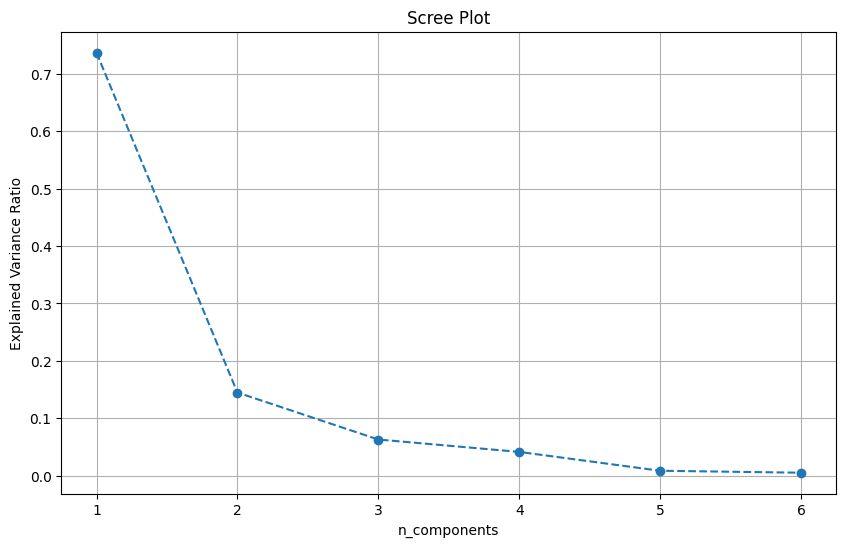

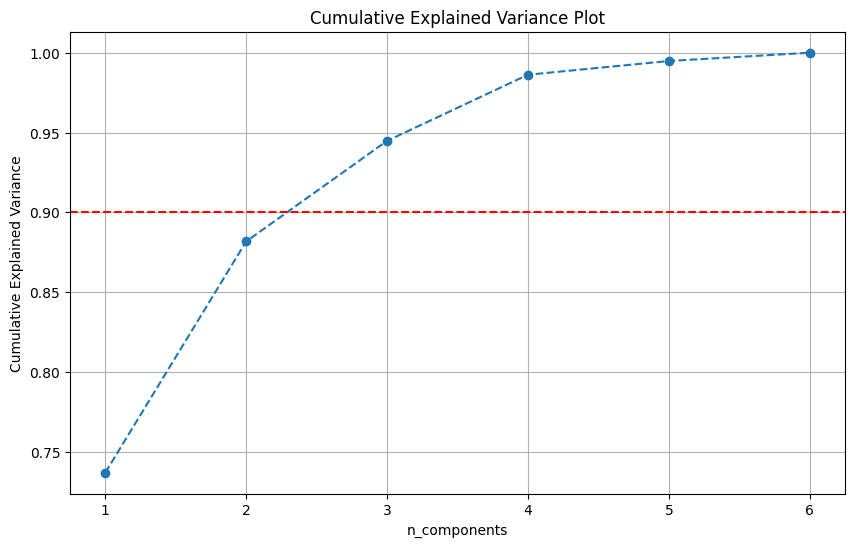

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

ev = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ev) + 1), ev, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('n_components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(ev) + 1, 1))
plt.grid()
plt.show()

# Optionally, you can also plot the cumulative explained variance
cumulative_variance = np.cumsum(ev)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance Plot')
plt.xlabel('n_components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(np.arange(1, len(cumulative_variance) + 1, 1))
plt.grid()
plt.axhline(y=0.90, color='r', linestyle='--')  # Example threshold at 90%
plt.show()

Our PCA will perform best when using 3 components, as seen by the plots above. SVD Could have also been used to determine the number of components, as we have previously done in class.

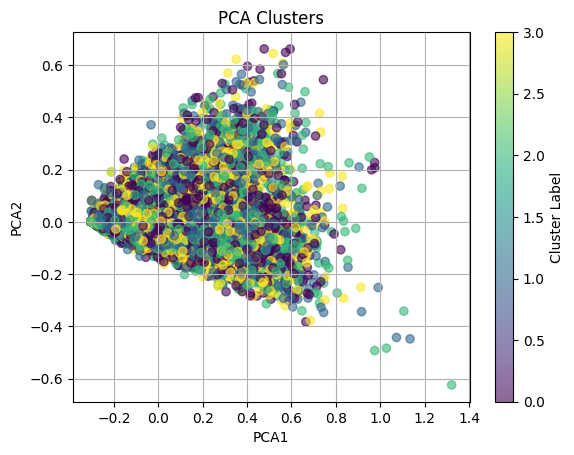

In [ ]:
pca = PCA(n_components= 3)
pca_df = pd.DataFrame(pca.fit_transform(X_train))
pca_df['Labels'] = nbadf_2.PPG_Bins

plt.figure()
plt.scatter(pca_df[0], pca_df[1],
            c=pca_df['Labels'],
            alpha=0.6)
plt.title('PCA Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.show()

In [ ]:
feature = 0
hi_feat = -1
hi_weight = -1
for i in pca.components_[0]:
    if i > hi_weight and i > 0:
        hi_feat = feature
        hi_weight = i
    feature += 1

print('Feature with the heighest positive weight:')
print(hi_feat, hi_weight)

Feature with the heighest positive weight:
2 0.5590926561526263


Our dataset results in poor PCA clustering for a few reasons.\
First, our PCA graph has a wedge shape due to the abscence of negative values. This can also be seen by plotting a histogram of PPG; our data is right skewed as more players have small points scored per game, while a few "Power Forwards" score the bulk of a team's points.
The second reason is most likely due to the standardization performed on each variable prior to PCA.\
As such, we will be using SVD with 3 components

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=3, n_iter=1000, random_state=76)
svd.fit(X_train)
sv = svd.singular_values_

right_matrix = pd.DataFrame(svd.components_)
right_matrix.shape # lets check the shape

left_matrix = pd.DataFrame(svd.fit_transform(X_train))/ sv
left_matrix.shape

(19699, 3)

To better visualize what our SVD looks like, we will use a pairplot showing each of the 3 components of the left and right matrices we have created.

In [ ]:
import seaborn as sns
def generate_plot(svd):
    sv = svd.singular_values_
    left_matrix = pd.DataFrame(svd.transform(X_train)) / sv
    right_matrix = pd.DataFrame(svd.components_)

    # Left matrix pairplot
    plt.figure(figsize=(10, 8))
    sns.pairplot(left_matrix)
    plt.suptitle("Pairplot of Left Matrix (Transformed Features)", y=1.02)
    plt.show()

    # Right matrix pairplot
    plt.figure(figsize=(10, 8))
    sns.pairplot(right_matrix.T)
    plt.suptitle("Pairplot of Right Matrix (Components)", y=1.02)
    plt.show()

<Figure size 1000x800 with 0 Axes>

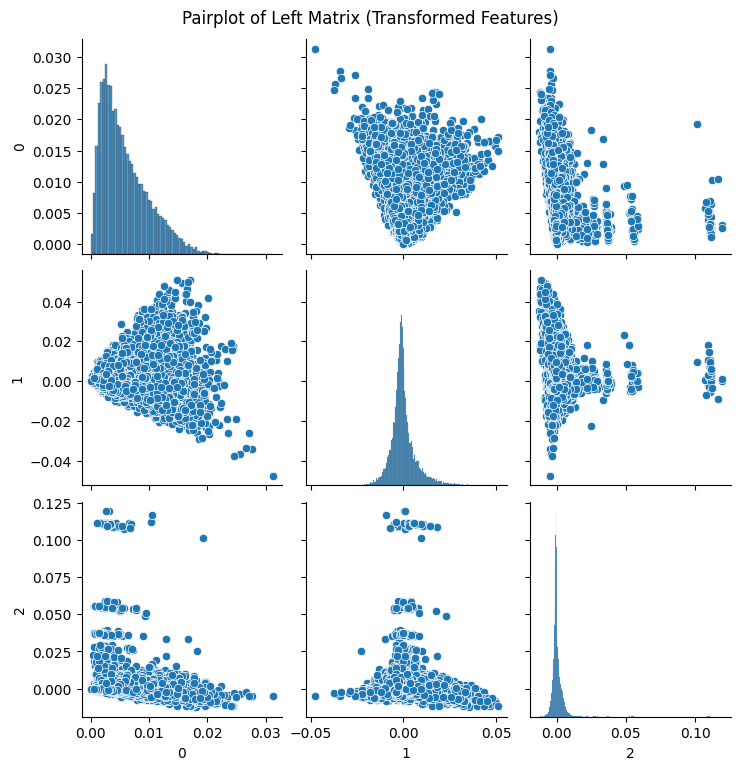

<Figure size 1000x800 with 0 Axes>

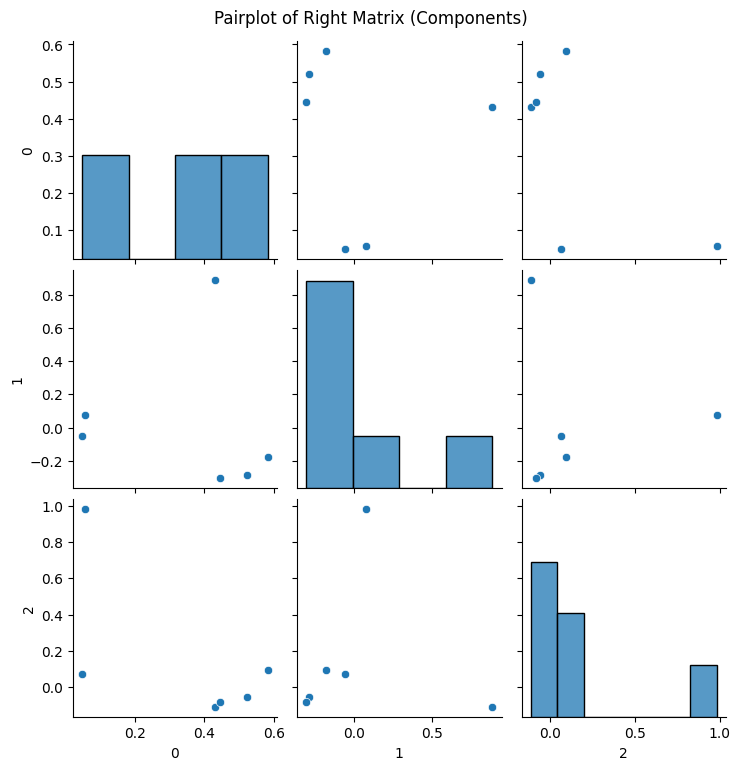

In [ ]:
generate_plot(svd)

Now we can see why our PCA did not produce good clusters. Our vertical plots of n=2 and n=3 show a unmimodal distribution. Had our data shown multiple peaks, clustering would have become more noticeable.

Due to the small amount of observations in our right matrix, very little significant information is available that the left matrix is does not already produce.

Finally, we can perform logistic regression by fitting a regressor on our transformed training data, predicting our test data, and comparing our resulting predictions with our actual y values using classification_report

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Transform both training and testing data using SVD
X_train_svd = pd.DataFrame(svd.transform(X_train), index=X_train.index)
X_test_svd = pd.DataFrame(svd.transform(X_test), index=X_test.index)

# Step 2: Fit a classifier on the transformed training data
classifier = LogisticRegression()
classifier.fit(X_train_svd, y_train)

# Step 3: Predict on the transformed test data
y_pred = classifier.predict(X_test_svd)

# Optional: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8456852791878172

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.90      1229
           1       0.79      0.77      0.78      1245
           2       0.79      0.80      0.80      1215
           3       0.92      0.89      0.91      1236

    accuracy                           0.85      4925
   macro avg       0.85      0.85      0.85      4925
weighted avg       0.85      0.85      0.85      4925



Our test accuracy hovers around roughly 84%. We would need to run these models again without seeding to determine its true efficacy

In [ ]:
y_pred2 = classifier.predict(X_train_svd)

# Optional: Evaluate the model
print("Accuracy:", accuracy_score(y_train, y_pred2))
print("\nClassification Report:\n", classification_report(y_train, y_pred2))

Accuracy: 0.8369968018681151

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.89      4926
           1       0.77      0.76      0.77      4911
           2       0.79      0.79      0.79      4942
           3       0.92      0.89      0.90      4920

    accuracy                           0.84     19699
   macro avg       0.84      0.84      0.84     19699
weighted avg       0.84      0.84      0.84     19699



Running the prediction on our training data also produces a similar accuracy score. This is indicative of the SVD improving our predictive probability when classifying Points Per Game as a categorical variable. Should we increase the bins (for example, from quartiles to deciles), our accuracy would decrease slightly, but it would provide a significantly better predictor in comparison to running linear regression on the normalized PPG.